In [2]:
import numpy as np
from openfermion.linalg import get_sparse_operator
from openfermion import QubitOperator
from scipy.linalg import expm

## Find coefficients of HOA
\begin{eqnarray}
    && Mq = D \\
    && where ~ D = [0,1,0,..,0]^T
\end{eqnarray}

M is referd in the paper and q is the coefficients we want. Therefore 
\begin{eqnarray}
    q = M^{-1}D
\end{eqnarray}

In [3]:
def Derive_q(S:int,s:float):
    """
    solve Simultaneous equations
    returns vector q as numpy.array
    """
    s = (S-1)/2
    M = []
    D = [0]*S
    D[1] = 1
    for i in range(S):
        M.append([])
        for j in range(S):
            M[-1].append((-s+j)**(i))
    M = np.array(M)
    q = np.linalg.inv(M)@D
    #q = np.round(np.linalg.inv(M)@D,15)
    #print(np.round(M@np.linalg.inv(M),8))
    return q

## Heisenberg Model

N: Number of spin (=qubits).
\begin{eqnarray}
    H = -J\sum_{i=0}^{N-2}\hat s_{i} \cdot\hat s_{i+1} - h\sum_{i=0}^{N-1}\hat Z_{i}
\end{eqnarray}

In [4]:
## Hamiltonian parameters
J,h,N=1,0.1,8

def HeisenbergQubitOperator(J,h,N):
    """
    returns hamiotonian as openfermion.ops.operators.qubit_operator.QubitOperator
    """
    hamiltonian = QubitOperator()
    spin2_list = []
    spin1_list = []

    for i in range(N):
        spin1_list.append("Z{}".format(i))
    for i in range(N-1):
        for j in ["X","Y","Z"]:
            spin2_list.append("{}{} {}{}".format(j,i,j,i+1))
    for i in range(N):
        hamiltonian += -h*QubitOperator(spin1_list[i])
    for i in range(3*(N-1)):
        hamiltonian += -J*QubitOperator(spin2_list[i])
    return hamiltonian

#print(type(HeisenbergQubitOperator(J,h,N)))
    

def Heisenberg_Hamiltonian(J,h,N):
    """
    returns Heisenberg hamiltonian as array
    """
    hamiltonian = HeisenbergQubitOperator(J,h,N)
    type(get_sparse_operator(hamiltonian,n_qubits=N))
    hamiltonian = get_sparse_operator(hamiltonian).toarray()
    return hamiltonian

#print(type(get_sparse_operator(HeisenbergQubitOperator(J,h,N),n_qubits=N)))

def Propagator(hamiltonian,t:float):
    """
    construct a time evolution of Heisenberg Hamiltonian: U=e^{-iHt}
    returns array of the unitary matrix
    """
    unitary_mtrx = expm(-1j * hamiltonian * t)
    return unitary_mtrx

def H_Diff(S:int,s:float,delta:float,hamiltonian):
    """
    construct HOA hamilotonian by size S and distance of neighboring points delta defined in the paper
    define J,h,N as macro parameter
    returns array of the HOA hamilotonian
    """
    veq_q = Derive_q(S=S,s=s)
    #s=(S-1)/2
    H = Propagator(hamiltonian,-s*delta)*veq_q[0]
    for i in range(1,S):
        H+=Propagator(hamiltonian,(-s+i)*delta)*veq_q[i]
    return 1j/delta * H


## Derive expectation (Using Numpy)

Let the state be $\left|+\right>$. Then, the expectation will be as following.
\begin{eqnarray}
    \left<+\left|^n -J\sum_{i=0}^{N-2}\hat s_{i} \cdot\hat s_{i+1} - h\sum_{i=0}^{N-1}\hat Z_{i} \right| + \right>^n = -J(N-1)
\end{eqnarray}

Below, $\left|+\right>$ is prepared by Hadamard Gate.

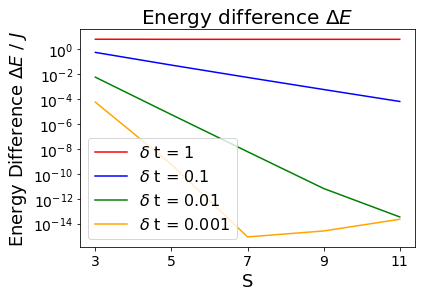

In [5]:
from qulacs import Observable
from qulacs.observable import create_observable_from_openfermion_text
from qulacs import QuantumState, QuantumCircuit
from qulacs.gate import H
import matplotlib.pyplot as plt
import numpy as np

qulacs_exact_hamilonian = create_observable_from_openfermion_text(str(HeisenbergQubitOperator(J,h,N)))

state = QuantumState(N)
for i in range(N):
    H(i).update_quantum_state(state)
#print(state)

array_state = np.array([(2**N)**-(0.5) for i in range(2**N)]) 
#print(array_state)

exact_value = qulacs_exact_hamilonian.get_expectation_value(state)
#print(exact_value)

exact_value = -J*(N-1)
list_S = [3,5,7,9,11]
list_s = [i+1.0 for i in range(len(list_S))]
#list_s = [0 for i in range(len(list_S))]

## compare theoritical value and HOA results
### delta_t = 1
list_approx_value = []
for S,s in zip(list_S,list_s):
    approx_value = array_state.T @ H_Diff(S=S,s=s,delta=1,hamiltonian=Heisenberg_Hamiltonian(J,h,N)) @ array_state
    list_approx_value.append(np.real(approx_value))
x=np.array(list_S)
y=np.abs(np.array(list_approx_value)-exact_value)
plt.plot(x,y,color='red',label="$\delta$ t = 1")

### delta_t = 0.1
list_approx_value = []
for S,s in zip(list_S,list_s):
    approx_value = array_state.T @ H_Diff(S=S,s=s,delta=0.1,hamiltonian=Heisenberg_Hamiltonian(J,h,N)) @ array_state
    list_approx_value.append(np.real(approx_value))
x=np.array(list_S)
y=np.abs(np.array(list_approx_value)-exact_value)
plt.plot(x,y,color='blue',label="$\delta$ t = 0.1")

### delta_t = 0.01
list_approx_value = []
for S,s in zip(list_S,list_s):
    approx_value = array_state.T @ H_Diff(S=S,s=s,delta=0.01,hamiltonian=Heisenberg_Hamiltonian(J,h,N)) @ array_state
    list_approx_value.append(np.real(approx_value))
x=np.array(list_S)
y=np.abs(np.array(list_approx_value)-exact_value)
plt.plot(x,y,color='green',label="$\delta$ t = 0.01")

### delta_t = 0.001
list_approx_value = []
for S,s in zip(list_S,list_s):
    approx_value = array_state.T @ H_Diff(S=S,s=s,delta=0.001,hamiltonian=Heisenberg_Hamiltonian(J,h,N)) @ array_state
    list_approx_value.append(np.real(approx_value))
x=np.array(list_S)
y=np.abs(np.array(list_approx_value)-exact_value)
plt.plot(x,y,color='orange',label="$\delta$ t = 0.001")


plt.title("Energy difference $\Delta E$",fontsize=20)
plt.xlabel('S',fontsize=18)
plt.ylabel('Energy Difference $\Delta E ~ / ~ J$',fontsize=18)
ax = plt.gca()
ax.set_yscale('log')
plt.grid([])
plt.xticks(list_S,fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16, loc='lower left')
plt.show()


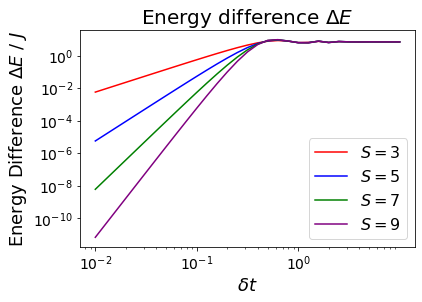

In [6]:
array_delta=10**np.linspace(-2,1,31)
### S=3
list_approx_value = []
for delta in array_delta:
    approx_value = array_state.T @ H_Diff(S=3,s=1,delta=delta,hamiltonian=Heisenberg_Hamiltonian(J,h,N)) @ array_state
    list_approx_value.append(np.real(approx_value))
x=np.array(array_delta)
y=np.abs(np.array(list_approx_value)-exact_value)
plt.plot(x,y,color='red',label="$S = 3$")

### S=5
list_approx_value = []
for delta in array_delta:
    approx_value = array_state.T @ H_Diff(S=5,s=2,delta=delta,hamiltonian=Heisenberg_Hamiltonian(J,h,N)) @ array_state
    list_approx_value.append(np.real(approx_value))
x=np.array(array_delta)
y=np.abs(np.array(list_approx_value)-exact_value)
plt.plot(x,y,color='blue',label="$S = 5$")


### S=7
list_approx_value = []
for delta in array_delta:
    approx_value = array_state.T @ H_Diff(S=7,s=3,delta=delta,hamiltonian=Heisenberg_Hamiltonian(J,h,N)) @ array_state
    list_approx_value.append(np.real(approx_value))
x=np.array(array_delta)
y=np.abs(np.array(list_approx_value)-exact_value)
plt.plot(x,y,color='green',label="$S = 7$")

### S=9
list_approx_value = []
for delta in array_delta:
    approx_value = array_state.T @ H_Diff(S=9,s=4,delta=delta,hamiltonian=Heisenberg_Hamiltonian(J,h,N)) @ array_state
    list_approx_value.append(np.real(approx_value))
x=np.array(array_delta)
y=np.abs(np.array(list_approx_value)-exact_value)
plt.plot(x,y,color='purple',label="$S = 9$")


plt.title("Energy difference $\Delta E$",fontsize=20)
plt.xlabel('$\delta t$',fontsize=18)
plt.ylabel('Energy Difference $\Delta E ~ / ~ J$',fontsize=18)
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.grid([])
plt.xticks([0.01,0.1,1],fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16, loc='lower right')
plt.show()